<a href="https://colab.research.google.com/github/JairEsc/Mat_Apl/blob/main/Opt_T8.2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Se define $g:\mathbb{R}^n\times \mathbb{R}^n⟶ \mathbb{R}$ como

$$g\left(\alpha^{j}, \mu^{j}\right)=\sum_{c \in \Omega}\left[h^{j}(c)-\sum_{i=1}^n \alpha_{i}^{j} \exp \left(\frac{-\left\|c-\mu_{i}^{j}\right\|_{2}^{2}}{2 \sigma^{2}}\right)\right]^{2}$$
Para $j=1,2$,

$\alpha^{j}=\left[\alpha_{1}^{j}, \alpha_{2}^{j}, \ldots, \alpha_{n}^{j}\right]$ son los pesos de la combinación lineal de la base radial. 

$\mu^{j}=\left[\mu_{1}^{j}, \mu_{2}^{j}, \ldots, \mu_{n}^{j}\right]$ son las medias de los elementos de la base radial. I.e. $\mu^{j}_{i}\in\mathbb{R}^3$

Parámetros como los histogramas $h^j$, un espacio de colores $\Omega=\{0,1,\ldots,b\}^3$ y un parámetro de amplitud $\sigma$ se consideran dados y fijos.

Nota: En la tarea se especifica $\mu^j\in\mathbb{R}^n$, así que supondré que $c-\mu_i^j$ significa $c-\mu_i^j(1,1,1)^T$.

In [122]:
import numpy as np
#Constantes----------------
sigma_sq=100**2
n_bins=8
hist_obj=np.loadtxt('H_0_8bins.txt',skiprows=1)
hist_fondo=np.loadtxt('H_1_8bins.txt',skiprows=1)
#---------------------------------
obj='obj'
#---------------------------------
def h(c,obj):
    if(obj=='obj'):
        return hist_obj[int(c[0]*(n_bins)**2+c[1]*(n_bins)+c[2])]
    else:
        return hist_fondo[int(c[0]*(n_bins)**2+c[1]*(n_bins)+c[2])]
def comb_base(Alpha_Mu,c):#Funcion auxiliar
    n=int(len(Alpha_Mu)/2)
    suma=0
    for i in range(n):
        suma+=Alpha_Mu[i]*np.exp(-(np.linalg.norm(c-Alpha_Mu[n+i])**2)/(2*sigma_sq))
    return suma
def fun_obj(Alpha_Mu):#Funcion objetivo
    g=0
    for r in range(n_bins):
        for gr in range(n_bins):
            for b in range(n_bins):
                #c=(r,g,b)
                c=np.array([int(r),int(gr),int(b)])
                g+=(h(c=c,obj=obj)-comb_base(Alpha_Mu,c))**2
    return g

#Gradiente conjugado---------------------------------

def GC(f,grad_f,Hessian_f,x_0,tol_g=10**(-5),max_iter=10**3):
    n=len(x_0)#Dimension del espacio
    d_0=-grad_f(x_0)
    k=0
    while(np.linalg.norm(grad_f(x_0))>=tol_g and k<max_iter):
        H=Hessian_f(x_0)
        alpha_k_gc=-(np.dot(grad_f(x_0),d_0))/(np.dot(d_0,np.dot(H,d_0)))#Tam. de paso
        x_0=x_0+alpha_k_gc*d_0
        g_km1=grad_f(x_0)
        beta_k_gc=(np.dot(d_0,np.dot(H,g_km1))/(np.dot(d_0,np.dot(H,d_0))))
        d_0=-g_km1+beta_k_gc*d_0
        k+=1
    print("iter",k)
    return x_0
#-----------------------------------
from scipy import optimize
n=3 #Base radial
def grad_f(Alpha_Mu):#Aproximacion del gradiente
    return optimize.approx_fprime(xk=Alpha_Mu, f=fun_obj,epsilon=10**(-6))
def Hessian_f(Alpha_Mu):#Aproximacion del Hessiano
  N = len(Alpha_Mu)
  hessian = np.zeros((N,N)) 
  gd_0 = grad_f(Alpha_Mu)
  eps = np.linalg.norm(gd_0)*10**(-6)
  for i in range(N):
    xx0 = 1.*Alpha_Mu[i]
    Alpha_Mu[i] = xx0 + eps
    gd_1 =  grad_f(Alpha_Mu)
    hessian[:,i] = ((gd_1 - gd_0)/eps)
    Alpha_Mu[i] =xx0
  return hessian
#Algoritmo de convergencia alternada
def optimizador_alternado(Alpha_Mu_0,tol_g=10**(-3),max_iter=10**3):
    #Definir gradientes parciales g_alpha_k, g_mu_k
    #minimizar g(g_alpha_k,g_mu_k) como función de g_alpha_k
    #Ese minimo es alpha_k+1
    #minimizar g(g_alpha_k+1,g_mu_k) como función de g_mu_k
    #Ese minimo es mu_k+1
    k=0
    n=int(len(Alpha_Mu_0)/2)
    Alpha_0, Mu_0=np.split(np.array(Alpha_Mu_0),2) #Condicion inicial
    print(fun_obj(Alpha_Mu_0))
    #while(np.linalg.norm(grad_g)>tol_g):
    for i in range(2):
        def fun_obj_alpha(Alpha_1):
            return fun_obj(np.concatenate((Alpha_1,Mu_0)))
        def fun_obj_mu(Mu_1):
            return fun_obj(np.concatenate((Alpha_0,Mu_1)))
        def grad_fun_obj_alpha(Alpha_1):
            return np.split(grad_f(np.concatenate((Alpha_1,Mu_0))),2)[0]
        def grad_fun_obj_mu(Mu_1):
            return np.split(grad_f(np.concatenate((Alpha_0,Mu_1))),2)[1]
        def Hessian_fun_obj_alpha(Alpha_1):
            return np.array(Hessian_f(np.concatenate((Alpha_1,Mu_0))))[0:n,0:n]
        def Hessian_fun_obj_mu(Mu_1):
            return np.array(Hessian_f(np.concatenate((Alpha_0,Mu_1))))[n:,n:]
        Alpha_1=GC(f=fun_obj_alpha,grad_f=grad_fun_obj_alpha, Hessian_f=Hessian_fun_obj_alpha,x_0=np.array(Alpha_0))#Calcular minimo.
        Alpha_0=Alpha_1#Actualizamos
        
        Mu_1=GC(f=fun_obj_mu,grad_f=grad_fun_obj_mu, Hessian_f=Hessian_fun_obj_mu,x_0=np.array(Mu_0))#Calcular minimo.
        Mu_0=Mu_1 #Actualizamos
        #Eso fue una iteracion
        #print(fun_obj(np.concatenate((Alpha_0,Mu_0))))
        print(np.concatenate((Alpha_0,Mu_0)))
#-----------------------------------
optimizador_alternado(Alpha_Mu_0=[4000,1100,5500,180,150,100])

6653728.824846285


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:697: RuntimeWarning: invalid value encountered in double_scalars
  df = (f(*((xk + d,) + args)) - f0) / d[k]


iter 1
iter 0
[-inf -inf -inf   1.   2.   3.]
iter 0
iter 0
[-inf -inf -inf   1.   2.   3.]


In [ ]:
#-----------------------------------

In [94]:
Alpha_Mu_obj=[-2.31492331e+06 , 2.75968981e+08, -9.06024982e+01 ,-1.31547659e+06,
  7.49159879e+06,  2.31003799e+03]
Alpha_Mu_fondo=[ 3698.0388068   ,  75.61184653 ,  -24.12458929 ,  591.0102304,
 -1018.33930575 , 1968.19042774]

In [112]:
#-----------------------------------
def clasificacion_fondo_objeto(img): #Usando la combinacion lineal de Gaussianas
    #recorrido sobre la imagen 
    row = img.shape[0]
    col = img.shape[1]
    for i in range(row):
        for j in range(col):
            #get color:
            c=img[i,j] #vector 3x1
            #decision:
            if(((comb_base(Alpha_Mu=Alpha_Mu_obj,c=c)+1)/(comb_base(Alpha_Mu=Alpha_Mu_obj,c=c)+comb_base(Alpha_Mu=Alpha_Mu_fondo,c=c)+1))>=.5):
                img[i,j,0]=255
                img[i,j,1]=0
                img[i,j,2]=0#Colorear
            else:
                img[i,j,0]=0
                img[i,j,1]=0
                img[i,j,2]=255#Colorear
    return img

In [108]:
#-----------------------------------
def clasificacion_fondo_objeto_histograma(img):
    #recorrido sobre la imagen 
    row = img.shape[0]
    col = img.shape[1]
    for i in range(row):
        for j in range(col):
            #get color:
            c=img[i,j] #vector 3x1
            #decision:
            if(((h(c=c,obj='obj')+0.01)/(h(c=c,obj='obj')+h(c=c,obj='fondo')+0.01))>.5):
                img[i,j,0]=255
                img[i,j,1]=0
                img[i,j,2]=0#Colorear
            else:
                img[i,j,0]=0
                img[i,j,1]=0
                img[i,j,2]=255#Colorear
    return img

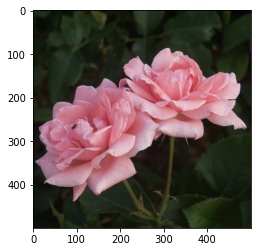

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


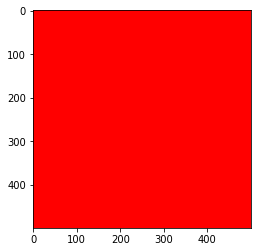

In [113]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('rose.png')
imgplot = plt.imshow(img)
plt.show()
imgplot = plt.imshow(clasificacion_fondo_objeto(img))
plt.show()

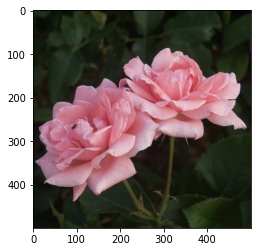

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


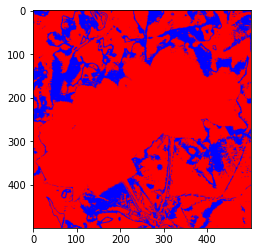

In [115]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('rose.png')
imgplot = plt.imshow(img)
plt.show()
imgplot = plt.imshow(clasificacion_fondo_objeto_histograma(img))
plt.show()